In [57]:
#importing modules required for our analysis
%reload_ext autoreload
%autoreload 2


%aimport evaluate

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import math
import os
from itertools import chain

#geopy modules used for geo-coding
import geopy
from geopy.distance import vincenty
import reverse_geocoder as rg


from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_validation import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from IPython.display import clear_output

import evaluate as eval
%matplotlib inline

### 1. Programmatically download and load the data into pandas dataframe, and report the shape of the data

In [3]:
#Downloading the data, if not present
if not os.path.exists('./gc_data_sept15.csv'):
    urllib.request.urlretrieve('https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv', './gc_data_sept15.csv')  

# load the data
greentaxi_data = pd.read_csv('./gc_data_sept15.csv')

print('Number of rows : {0} and columns : {1}'.format(greentaxi_data.shape[0],greentaxi_data.shape[1]))

Number of rows : 1494926 and columns : 21


#### 1.a Preprocessing 

Before diving into my analysis, let's explore the data in hand to preprocess/clean the data in hand to make our future operations easier.

In [4]:
#let's understand what the data is about, by taking a look at it's contents
print(str(greentaxi_data.columns) + '\n')

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type '],
      dtype='object')



On exploring the data contents, and also referring to data description provided here https://data.cityofnewyork.us/Transportation/2016-Green-Taxi-Trip-Data/hvrh-b6nb . I noticed a lot of scope for improving the data. However, for the sake of keeping this simple, I'm making few trivial preprocessing here before beginning the analysis.

In [5]:
## I Noticed two columns that fall under datatime category, so i'll be updating the type of the column to reflect the same
greentaxi_data.lpep_pickup_datetime = pd.to_datetime(greentaxi_data.lpep_pickup_datetime)
greentaxi_data.Lpep_dropoff_datetime = pd.to_datetime(greentaxi_data.Lpep_dropoff_datetime)

In [6]:
## For records with invalid/missing values, we can either ignore or replace the values with their mean.
## And Since we have more then a million records, I'll take my chances by removing rows with invalid/missing values
print('I noticed there are nearly {0} records with 0 as pickup coords and {1} records with 0 as dropoff coords. \
Since this number is quite small relative to overall dataset, let\'s remove these\
 rows.'.format(greentaxi_data[greentaxi_data['Pickup_latitude']==0].shape[0], \
             greentaxi_data[greentaxi_data['Dropoff_latitude']==0].shape[0]))

I noticed there are nearly 2110 records with 0 as pickup coords and 1963 records with 0 as dropoff coords. Since this number is quite small relative to overall dataset, let's remove these rows.


In [7]:
greentaxi_data = greentaxi_data[greentaxi_data['Pickup_latitude']!=0]
greentaxi_data = greentaxi_data[greentaxi_data['Dropoff_latitude']!=0]


In [8]:
#removing unnecessary space in column name 'Trip_type ', instead let's just replace all spaces with _
greentaxi_data.columns = greentaxi_data.columns.str.replace('\s+', '_')  # in case there are multiple white spaces
#this would be troublesome later, since it's categorical attribuet
greentaxi_data['Trip_type_'] = greentaxi_data['Trip_type_'].astype(int)

In [9]:
# The Ehail_fee seems NaN for all the records, let's drop the column
print(greentaxi_data.shape)
greentaxi_data = greentaxi_data.drop(['Ehail_fee'],axis=1)
print(greentaxi_data.shape)

(1491377, 21)
(1491377, 20)


This should be good amount of pre-processing for now, However I did notice a couple of things like, trip_distance being too huge or short as 0, passenger_count being 0 and Fare amount/ Total amount in negative. Also these values doesn't make sense entirely, I have different hypothesis for each of the situations.  
1. **Trip Distance** : For values that are 0, passenger might have immediately decided to not continue with the assigned cab as soon as they got in for whatever reasons.
2. **Total amount/Fare Amount** : For values that are 0, it may have happened that passengers might have applied a promo code which provides free rides to an event. In some places Lyft/Other taxi services provide free services to Students. It could be the same here. 

We might lose such trends, so I'll retain these records for now and decide whether to keep/leave them depending on the type of analysis at a later point.

### 2. Trip Distance Analysis

On a personal note, I'd use taxis for short rides and use much cheaper modes of transportation for longer routes.New York City Subway is well connected and I'd usually prefer that mode for long distance rides.

On a general note, The distance might be uniform over a large population of riders. Since, people's lifestyle and reasons differ. So, let's take a broad look at the distribution before we proceed to plot the histogram.

In [10]:
#summarizing the trip distance
tripDistance_summary = greentaxi_data.Trip_distance.describe()
print(tripDistance_summary,'\nNotice, How the max Trip is around 600 miles! It\'s clearly an outlier that we would have to filter out')

count    1.491377e+06
mean     2.971604e+00
std      3.076073e+00
min      0.000000e+00
25%      1.100000e+00
50%      1.980000e+00
75%      3.740000e+00
max      6.031000e+02
Name: Trip_distance, dtype: float64 
Notice, How the max Trip is around 600 miles! It's clearly an outlier that we would have to filter out


Axes(0.125,0.125;0.352273x0.755)
Axes(0.547727,0.125;0.352273x0.755)


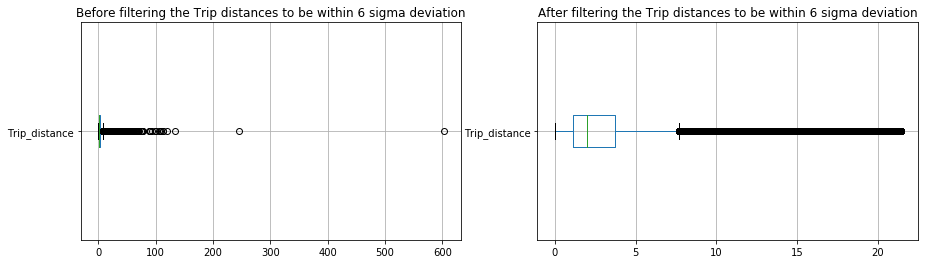

In [11]:
fig,ax = plt.subplots(1,2,figsize = (15,4)) 
print(greentaxi_data.boxplot(column='Trip_distance', vert=False, ax=ax[0]))
ax[0].set_title('Before filtering the Trip distances to be within 6 sigma deviation')
#clearly a lot of outliers exist beyond the whisker, so let's filter the data to fall within 6 sigma deviation
six_sigma = 6*tripDistance_summary['std']
mean = tripDistance_summary['mean']
min_bound = mean - six_sigma
max_bound = mean+ six_sigma

## Since we are trying to understand a general distribution of Trip Distance and not specific use case scenarios when it's zero 
## let's drop the values that are outliers
greentaxi_data = greentaxi_data[ greentaxi_data.Trip_distance > min_bound]
greentaxi_data = greentaxi_data[ greentaxi_data.Trip_distance < max_bound]
#let's see the box plot again
ax[1].set_title('After filtering the Trip distances to be within 6 sigma deviation')
print(greentaxi_data.boxplot(column='Trip_distance', vert=False, ax=ax[1]))

We can see that the max trip distance is now between 20-25. We can proceed to plot the histogram now, but before doing
 that, let's compute the best suited bin size using *Freedman-Diaconis rule*.

In [12]:
def getBinSize(data_distribution):
    count = data_distribution['count']
    Q3 = data_distribution['75%']
    Q1 = data_distribution['25%']
    IQR = Q3-Q1
    h = 2 * IQR * np.cbrt(count)
    bin_width = (data_distribution['max'] - data_distribution['min'] / h)
    return (bin_width)

In [13]:
tripDistance_summary = greentaxi_data.Trip_distance.describe()
bin_width = math.ceil(getBinSize(tripDistance_summary))
print('Bin Size using filtered data : {0} '.format(bin_width))

Bin Size using filtered data : 22 


Axes(0.125,0.125;0.775x0.755)


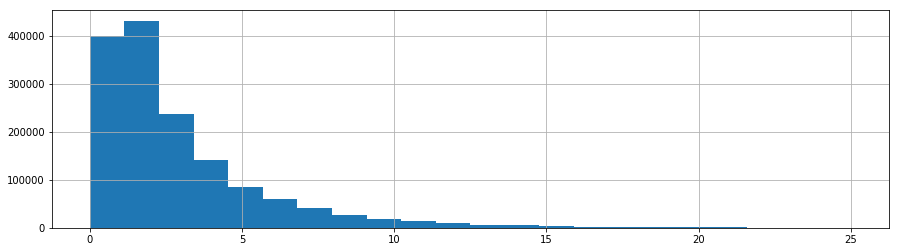

In [14]:
print(greentaxi_data.Trip_distance.hist(bins=bin_width,figsize=(15,4), range=[0,25]))

The distribution is right skewed, which reflects a trend in which New Yorkers use Green Taxi. If the distribution was random, we could have expected a much more uniform curve. It seems a majority of New Yorkers use taxi cab for short rides less then 5 miles. Probably for commuting between office and home or going around cool city spots (we can analyse the pickup and drop co-ordinates to get a trend on most visited spots by New Yorkers).

### 3. Analysing Trip distance throughout a day on an average 

To understand the trend on how New Yorkers commute during different times in a day, we can group data for pickup hours over a month. This ideally provide us some information about how New Yorkers commute and also introduce us to peak hours *(We can more clearly gather peak hours information by aggregating the data based on count as well)*.

To perform such analysis we need to derive a pickup_hour feature from our original pickup timestamp :

In [15]:
greentaxi_data['lpep_pickup_hour'] = greentaxi_data.lpep_pickup_datetime.apply(lambda x:x.hour)

We can aggregate the enriched dataframe based on hour to compute the mean and median of trip_distances

In [16]:
trip_distance_analysis = pd.pivot_table(greentaxi_data,values='Trip_distance',index=['lpep_pickup_hour'], aggfunc=('mean','median'))
print(trip_distance_analysis)

                      mean  median
lpep_pickup_hour                  
0                 3.088108    2.20
1                 2.987526    2.12
2                 3.011631    2.14
3                 3.149565    2.20
4                 3.469498    2.35
5                 4.070486    2.90
6                 3.967659    2.83
7                 3.241248    2.17
8                 3.011294    1.98
9                 2.959812    1.96
10                2.904888    1.91
11                2.861838    1.87
12                2.864586    1.89
13                2.834942    1.84
14                2.820025    1.82
15                2.811727    1.81
16                2.744149    1.80
17                2.648210    1.78
18                2.628751    1.80
19                2.695580    1.85
20                2.752623    1.90
21                2.967541    2.03
22                3.148952    2.20
23                3.168033    2.22


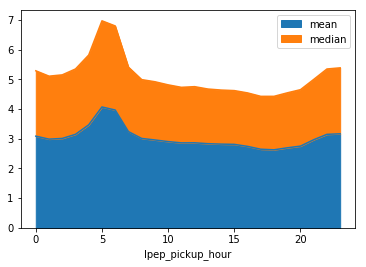

In [17]:
trip_distance_analysis.plot.area()

The above area plot and the spreadsheet values show us the spread of Trip Distance over different hours in a day. Notice that hour 4 AM there is a slight increase in commute distance that contiues to peak around 5 AM, and gradually fall to normal level at around 7 AM. The curve falls to it's lowest around between 4 PM - 6 PM, before it continues to raise to some extent at Midnight.  

Some thoughts, on this would be *maybe folks who are commuting early in the morning are probably getting an headstart on their long ride from Home to Office or commuting to airports*.  

We see a drop in the evenings, but we could have expected this to be high since folks would be heading back from work around that time frame. However, it's not the scenario reflected here. One possible hypothesis could be that most New Yorkers prefer to take alternate modes of transportation like Subway during peak hours when the traffic is expected to be high. *(We can confirm this hypothesis by gathering such data from NYC SubWay and traffic information)*

### 3.b Airport Ride analysis

For our next part of the analysis, we'd need to filter the original data to derive only those rides which have airports as either their pickup or drop point.

While gathering information based on coordinates, I noticed that apart from the Major airports in New York like **JFK** and **Laguardia**, there were rides from/to **Newark Liberty International Airport**. This is interesting since Newark Airport is quite far from New York, so let's check if this is a common trend.

*Note : I'm using an external api called geopy to calculate the distance between pickup/drop points and these airports and considering rides that fall within 1 mile radius of these airports as airport rides*.

I did observe a field named **RatecodeId** that suggests certain id for *JFK and Newark*, but on verifying those records with the ones that I was able to get from below, This was more accurate. I was able to get airport rides that had RateCodeID beyond 2 & 3 which were mentioned in the data dictionary. So, I decided to stick with this approach to get airport rides.

In [18]:
# return 1 if pickup/drop is close to airport
def closeToAirport(airport, pickup_point, drop_point):
    return 1 if (vincenty(airport, pickup_point).miles < 1) or (vincenty(airport, drop_point).miles < 1) else 0

In [19]:
JFK_coords = (40.6413111, -73.7781391) 
Newark_coords = (40.6895314,-74.17446239999998)
laguardia_coords = (40.7769271, -73.87396590000003)

In [20]:
#adding a safety check to avoid unnecessary re-computations if I accidentally run the cell
def enrich_airport_info(greentaxi_data, override=False):
    if 'JFK_airport' not in greentaxi_data.columns or override:
        greentaxi_data['JFK_airport'] = greentaxi_data.apply(lambda x: closeToAirport(JFK_coords, (x['Pickup_latitude'],x['Pickup_longitude']), (x['Dropoff_latitude'],x['Dropoff_longitude']) ), axis=1)
    if 'Newark_airport' not in greentaxi_data.columns or override:
        greentaxi_data['Newark_airport'] = greentaxi_data.apply(lambda x: closeToAirport(Newark_coords, (x['Pickup_latitude'],x['Pickup_longitude']), (x['Dropoff_latitude'],x['Dropoff_longitude']) ), axis=1)
    if 'LaGuardia_airport' not in greentaxi_data.columns or override:
        greentaxi_data['LaGuardia_airport'] = greentaxi_data.apply(lambda x: closeToAirport(laguardia_coords, (x['Pickup_latitude'],x['Pickup_longitude']), (x['Dropoff_latitude'],x['Dropoff_longitude']) ), axis=1)
    return greentaxi_data

In [21]:
greentaxi_data = enrich_airport_info(greentaxi_data)
airport_rides  = greentaxi_data[ (greentaxi_data['JFK_airport'] ==1) | (greentaxi_data['Newark_airport'] ==1) | (greentaxi_data['LaGuardia_airport'] ==1)  ] 

In [22]:
print('There were in total of {0} Airport Rides'.format(airport_rides.shape[0]))

There were in total of 41787 Airport Rides


In [23]:
airport_rides.Fare_amount.describe()

count    41787.000000
mean        25.818955
std         15.594533
min        -45.000000
25%         12.000000
50%         22.500000
75%         37.000000
max        450.000000
Name: Fare_amount, dtype: float64

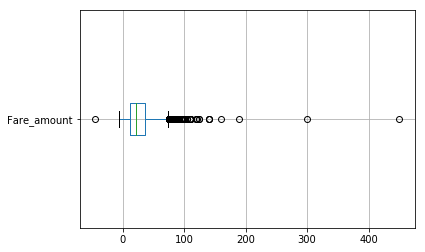

In [24]:
airport_rides.boxplot(column='Fare_amount', vert=False)

Similar to how we noticed outliers while analysing Trip Distances, there are few outliers here as well. Let's remove the outliers before computing the mean of the data

In [25]:
fareAmount_summary = airport_rides.Fare_amount.describe()
six_sigma = 6*fareAmount_summary['std']
mean = fareAmount_summary['mean']
max_bound = mean+ six_sigma
airport_rides = airport_rides[ airport_rides.Fare_amount > 0]
airport_rides = airport_rides[ airport_rides.Fare_amount < max_bound]

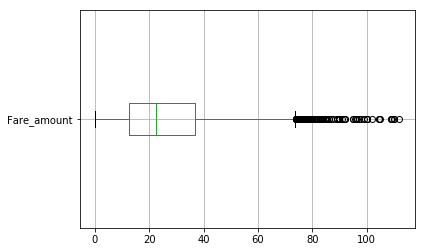

In [26]:
airport_rides.boxplot(column='Fare_amount', vert=False)

In [27]:
airport_rides.Fare_amount.describe()

count    41631.000000
mean        25.866530
std         15.243634
min          0.010000
25%         12.500000
50%         22.500000
75%         37.000000
max        112.000000
Name: Fare_amount, dtype: float64

On an average we see that airport rides fare is around 25$

** While analysing, I observerd there were few rides that had both JFK and Laguardia listed as true. ** Where these rides really originating from one airport and was dropped at another? Infact, it was indeed. On googling these coordinates I was able to get either pickup or destination as one or the other airport.

In [28]:
jfk_laguardia = airport_rides[  (airport_rides['JFK_airport'] ==1) & (airport_rides['LaGuardia_airport'] ==1)  ]

In [29]:
jfk_laguardia.Fare_amount.describe()

count    64.000000
mean     25.147656
std      10.226822
min      16.500000
25%      16.500000
50%      16.525000
75%      33.500000
max      60.000000
Name: Fare_amount, dtype: float64

Nearly 50% of the rides have a minimum fare, beyond which we can notice the fare may go as high as upto 60

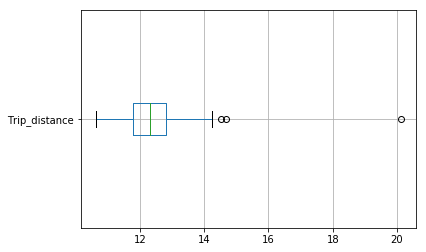

In [30]:
jfk_laguardia.boxplot(column='Trip_distance', vert=False)

We can notice that the Trip distance is quite consistent and spread between 10 and 14 miles at max with few outliers and at an average of 12 miles.

### 4. Tip Percent Analysis

We can calculate the tip percent using (tip_amount/total_amount) * 100. Let's derive the variable for the taxi data set.

In [31]:
greentaxi_data['tip_percent'] = greentaxi_data.apply(\
                                    lambda ride: 0 if ride['Total_amount'] ==0 \
                                                else ((ride['Tip_amount']*100)/ride['Total_amount']),\
                                    axis=1)

There were certain rides which had tip_percent as 100, these could be erraneous or genuine tips, we are not sure. However, to generalize the analysis, let's seperate these rides from the overall data and analyze it later. 

In [32]:
tip_percent_100 = greentaxi_data[greentaxi_data['tip_percent'] == 100]

In [33]:
greentaxi_data = greentaxi_data[greentaxi_data['tip_percent'] < 100]

Let's see the distribution of the tip_percent using this filtered data.

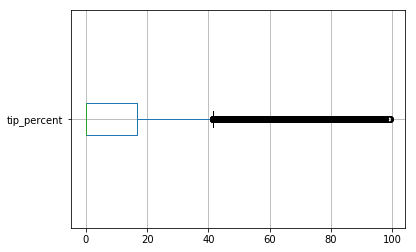

In [34]:
greentaxi_data.boxplot(column='tip_percent', vert=False)

We can notice that inspite of filtering out tip_percent which were exactly 100, there seems to be rides with almost 100% tip. Let's filter these out using six sigma deviation as above.

In [35]:
tipPercent_summary = greentaxi_data.tip_percent.describe()
six_sigma = 6*tipPercent_summary['std']
mean = tipPercent_summary['mean']
max_bound = mean+ six_sigma
greentaxi_data = greentaxi_data[ greentaxi_data.tip_percent < max_bound]

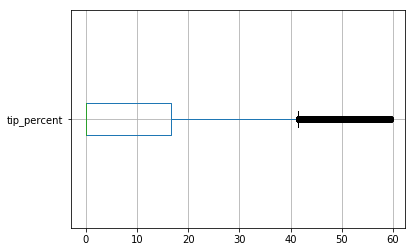

In [36]:
greentaxi_data.boxplot(column='tip_percent', vert=False)

Axes(0.125,0.125;0.775x0.755)


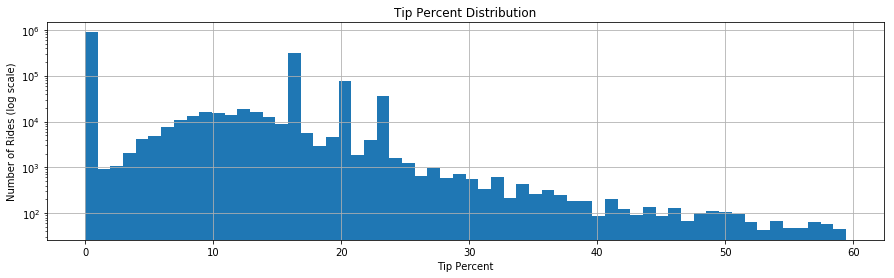

In [37]:
tip_bin_width = math.ceil(getBinSize(greentaxi_data.tip_percent.describe()))
fig,ax = plt.subplots(figsize = (15,4))
#Since the number of rides with zero tip_percent is significantly higher then rest, I'm taking the
# number of records in log scale to be able to understand the pattern
ax.set_yscale('log')
ax.set_xlabel('Tip Percent')
ax.set_ylabel('Number of Rides (log scale)')
ax.set_title('Tip Percent Distribution')
print(greentaxi_data.tip_percent.hist(bins=tip_bin_width,figsize=(15,4)))

The right skewed distribution here shows that majority of New Yorkers tip within 25% of their Total Fare amount.
Also, It's interesting to see those **4 peaks** within the distribution. *One possible hypothesis is these could be one of the default options while selecting the tip percent, i.e (0 , 10, 15, 20, 25)*.   
Usually, if the total amount is less then 10$, folks tend to tip 10% otherwise a minimum of 15%. This could be the reason why we don't see a spike at 10%. (For now, I'll not dig deeper here)

In [39]:
greentaxi_data.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'improvement_surcharge', 'Total_amount',
       'Payment_type', 'Trip_type_', 'lpep_pickup_hour', 'JFK_airport',
       'Newark_airport', 'LaGuardia_airport', 'tip_percent'],
      dtype='object')

#### 4.2 Predicitive model with tip_percent as target

*For my further analysis, I referred a paper https://cseweb.ucsd.edu/classes/wi17/cse258-a/reports/a075.pdf to base my initial assumptions and approach.*  
Since tip percent, may rely on lot factors including geographical, I decided to enrich the original data to leverage certain features like boroughs/county's where the ride happened.
Also, due to some time consuming tasks that I'll be running going forward, I have decided to use only a subset of the original data. I'll keep the model simple to cover the important aspects of building a model, but will not be spending too much time optimizing the performance.

In [40]:
# defining a class to derive county information based on pickup and dropoff coordinates
class GeoCoder():
    
    def __init__ (self, dataframe):
        self.dataframe = dataframe

    def getEncodedDf(self, dataframe = None, override = False):
        if (dataframe is None):
            dataframe = self.dataframe
          
        if ( ('Pickup_borough' in dataframe.columns or 'Dropoff_borough' in dataframe.columns ) and not override):
            return dataframe
        prev = pd.options.mode.chained_assignment
        pd.options.mode.chained_assignment = None
        pickp_points = [ (each[0],each[1]) for each in np.transpose(np.asarray((dataframe['Pickup_latitude'],dataframe['Pickup_longitude'])))]
        dropoff_points = [ (each[0],each[1]) for each in np.transpose(np.asarray((dataframe['Dropoff_latitude'],dataframe['Dropoff_longitude'])))]
        pickp_points = rg.search(pickp_points)
        dropoff_points = rg.search(dropoff_points)
        
        dataframe['Pickup_borough'] = [each['admin2'].split(' County')[0] if each['admin2'] is not '' else 'Unknown' for each in pickp_points]
        dataframe['Dropoff_borough'] = [each['admin2'].split(' County')[0] if each['admin2'] is not '' else 'Unknown' for each in dropoff_points]
        
        # We are formatting the county names in their respective borough names
        dataframe.loc[dataframe['Pickup_borough'] == 'New York','Pickup_borough'] = 'Manhattan'
        dataframe.loc[dataframe['Pickup_borough'] == 'Kings','Pickup_borough'] = 'Brooklyn'
        dataframe.loc[dataframe['Pickup_borough'] == 'Richmond','Pickup_borough'] = 'Staten Island'

        dataframe.loc[dataframe['Dropoff_borough'] == 'New York','Dropoff_borough'] = 'Manhattan'
        dataframe.loc[dataframe['Dropoff_borough'] == 'Kings','Dropoff_borough'] = 'Brooklyn'
        dataframe.loc[dataframe['Dropoff_borough'] == 'Richmond','Dropoff_borough'] = 'Staten Island'

        print('Unique Pickup Boroughs : {0} \nUnique DropOff Boroughs : {1} \n'.format(np.unique(dataframe.Pickup_borough), np.unique(dataframe.Dropoff_borough)) )
        pd.options.mode.chained_assignment = prev
        return(dataframe)


In [41]:
class EnrichFeatures():
    
    def __init__(self,dataframe):
        self.dataframe = dataframe
    
    def getEnrichedDf(self,dataframe=None, override = False):
        if (dataframe is None):
            dataframe = self.dataframe
        
        #adding airport details
        dataframe_AirportInfo = enrich_airport_info(dataframe, override)
        
        #adding borough details
        gCoder = GeoCoder(dataframe_AirportInfo)
        enrichedDF = gCoder.getEncodedDf(override = override)
        
        return enrichedDF
    

In [42]:
featurizer = EnrichFeatures(greentaxi_data)
enrichedData = featurizer.getEnrichedDf()

Loading formatted geocoded file...
Unique Pickup Boroughs : ['Atlantic' 'Bergen' 'Bronx' 'Brooklyn' 'Delaware' 'Essex' 'Fairfield'
 'Hudson' 'Manhattan' 'Middlesex' 'Monmouth' 'Montgomery' 'Nassau'
 'New Haven' 'Oakland' 'Ocean' 'Orange' 'Passaic' 'Pike' 'Queens'
 'Rockland' 'Somerset' 'Staten Island' 'Strafford' 'Suffolk' 'Tolland'
 'Union' 'Unknown' 'Westchester'] 
Unique DropOff Boroughs : ['Atlantic' 'Bergen' 'Bronx' 'Brooklyn' 'Bucks' 'Burlington' 'Delaware'
 'Essex' 'Fairfield' 'Hudson' 'Manhattan' 'Middlesex' 'Monmouth' 'Nassau'
 'New Haven' 'Oakland' 'Ocean' 'Orange' 'Passaic' 'Pike' 'Queens'
 'Rockland' 'Somerset' 'Staten Island' 'Suffolk' 'Tolland' 'Union'
 'Unknown' 'Wayne' 'Westchester'] 



Notice that the dataset has many counties that are part of New York State and also New Jersey. We'll visualize both of these, but for building the model I'll taken only the New york city ride information

In [43]:
nyc_borough_rides = enrichedData[enrichedData['Dropoff_borough'].isin(['Brooklyn','Bronx','Manhattan','Staten Island','Queens'])]
nyc_borough_rides = nyc_borough_rides[nyc_borough_rides['Pickup_borough'].isin(['Brooklyn','Bronx','Manhattan','Staten Island','Queens'])]

In [44]:
predictors = [ 'Payment_type', 'Trip_type_','lpep_pickup_hour','RateCodeID',\
              'JFK_airport', 'Newark_airport', 'LaGuardia_airport',\
              'Pickup_borough','Dropoff_borough','Store_and_fwd_flag',\
              'Passenger_count', 'Trip_distance', 'Fare_amount', \
              'Extra', 'MTA_tax','Tip_amount', 'Tolls_amount', 'improvement_surcharge','Total_amount']
# defining a transformation step, to transform all the categorical attributes to numerical by one hot encoding using sklearn binarizer
def featurize(predictors):
    transformations = [(['Payment_type', 'Trip_type_','lpep_pickup_hour','RateCodeID',\
                              'JFK_airport', 'Newark_airport', 'LaGuardia_airport',\
                              'Pickup_borough','Dropoff_borough','Store_and_fwd_flag'], LabelBinarizer(sparse_output=True)),
                            (['Passenger_count', 'Trip_distance', 'Fare_amount', \
                              'Extra', 'MTA_tax','Tip_amount', 'Tolls_amount', \
                              'improvement_surcharge','Total_amount'], None)]
    
    transformations = list(chain(*list(map(lambda x: [(each,x[1]) for each in x[0]],transformations) ) ) )
    return DataFrameMapper(list(filter(lambda x: x[0] in predictors, transformations)))

In [45]:
target = list(nyc_borough_rides['tip_percent'])
features = pd.DataFrame(data=nyc_borough_rides.drop(['tip_percent'],axis=1))
fearures = features.reset_index()

In [72]:
X_train, X_test, y_train, y_test = train_test_split(features[:25000], target[:25000], test_size = 0.4, random_state = 20)
X_train = X_train.reset_index().drop(['index'],axis=1)
X_test = X_test.reset_index().drop(['index'],axis=1)

In [73]:

pipeline = Pipeline([('featuriz', featurize(features)), ('forest', RandomForestRegressor())])
cv_sets = ShuffleSplit(X_train.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)


/Users/rvsandeep/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


checking import


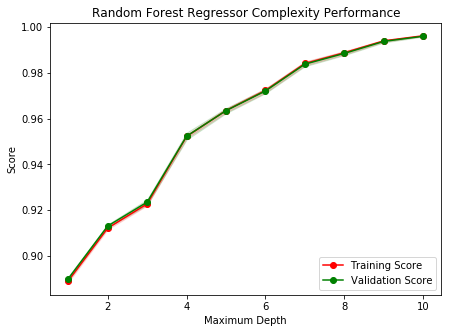

In [52]:
eval.ModelComplexity(pipeline.steps[0][1].fit_transform(X_train.copy()),y_train)

Model Complexity graph provides us information on how the score of the model varies as we increase the complexity of the model. Since I'm using RandomForestRegressor, I'm depending on max depth of the tree as the complexity measure and keeping all the other attribtes constant.

Based on the result, we can see that a model with 10 depth is providing an optimal score. 
We can reconfirm this later by fitting the data using grid search to derive the best model

/Users/rvsandeep/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


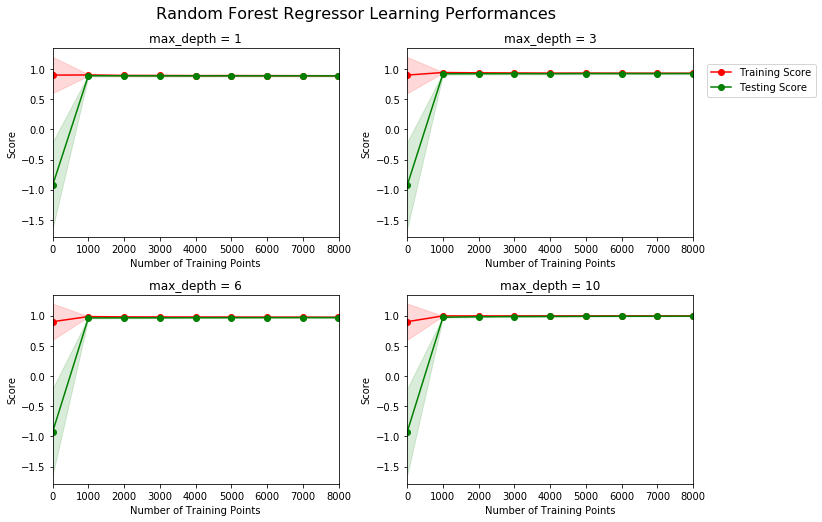

In [58]:
eval.ModelLearning(pipeline.steps[0][1].fit_transform(X_train[:10000].copy()),y_train[:10000])

Model learning curves helps us understand how number of training points and max depth play a factor for training and testing score.

We can observe that after a certain number of training points, the curves converge and become smooth. Beyond these many samples, no matter how many samples get added, the performance of the model doesn't vary much. This shows us whether we would need to use the entire training data or subsample such that we take a sample that provides the best score.

In [74]:
# Based on above learnings, we can sample the data or tune the hyperparameter more close to the ones 
# that performed well.
params = {'forest__max_depth':(2,3,4,7,10)}
grid = GridSearchCV(pipeline,param_grid=params, cv=cv_sets)

In [75]:
best_pipeline = grid.fit(X_train.reset_index().drop(['index'],axis=1).copy(), y_train).best_estimator_


In [76]:
# We can use the best pipeline estimated by our Grid Search model to further make predictions on the test dataset
r2_score(y_test,best_pipeline.predict(X_test))

0.99656184971568018

In [77]:
best_pipeline.steps

[('featuriz', DataFrameMapper(default=False, df_out=False,
          features=[('Payment_type', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=True)), ('Trip_type_', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=True)), ('lpep_pickup_hour', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=True)), ('RateCodeID', LabelBinarizer(neg_label=0, pos_l...Tip_amount', None), ('Tolls_amount', None), ('improvement_surcharge', None), ('Total_amount', None)],
          input_df=False, sparse=False)),
 ('forest',
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0, warm_start=False))]

We can confirm that the best forest has a max depth of 10.

### Option B - Visualizing Intra - Inter borough rides

Along with boroughs, Since I was able to get a lot of county information, I'll visualize as a whole as well.

**Visualizing borough can be found here,
http://rvsandeep.com/nycanalytics/borough/**

In [78]:
grouped_boroughs = nyc_borough_rides.groupby(['Pickup_borough','Dropoff_borough']).size().reset_index(name='count')

In [79]:
grouped_boroughs['pickup-dropoff'] = pd.Series(['-'.join(row.astype(str)) for row in grouped_boroughs[['Pickup_borough','Dropoff_borough']].values], index=grouped_boroughs.index)

Pre-processing to generate the aggregate of pickup-dropoff for visualizing using D3.JS 

In [80]:
grouped_boroughs[['pickup-dropoff','count']].to_csv('./borough_rides.csv',index=False)

**Visualizing overall county can be found here, http://rvsandeep.com/nycanalytics/county/**

In [83]:
overall_rides = enrichedData
overall_rides = overall_rides[overall_rides['Pickup_borough'] != 'Unknown']
overall_rides = overall_rides[overall_rides['Dropoff_borough'] != 'Unknown']

In [84]:
grouped_county = overall_rides.groupby(['Pickup_borough','Dropoff_borough']).size().reset_index(name='count')

In [85]:
grouped_county['pickup-dropoff'] = pd.Series(['-'.join(row.astype(str)) for row in grouped_county[['Pickup_borough','Dropoff_borough']].values], index=grouped_county.index)

In [86]:
grouped_county[['pickup-dropoff','count']].to_csv('./county_rides.csv',index=False)